In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
# Offline changepoint detection
def changepoint_detection(data, hazard_function, distribution):
    length = len(data)
    H = hazard_function(np.arange(length + 1))
    Pr = np.zeros((length + 1, length + 1))    # length + 1 b/c 0 is for priors
    # Pr[r, t] = P(r_t=r, x_1:t)

    Pr[0, 0] = 1
    for t, x in enumerate(data):
        t += 1    # t=0 is for priors stuff. First data point is @ t=1
        predprobs = distribution.pdf(x)
        Pr[1:t + 1, t] = Pr[:t, t - 1] * predprobs * (1 - H[:t])
        Pr[0, t] = np.sum(Pr[:t, t - 1] * predprobs * H[:t])
        Pr[:, t] /= np.sum(Pr[:, t])    # normalize probabilities
        distribution.update(x)
    return Pr

In [3]:
class BayesianChangepointDetection(object):
    def __init__(self, hazard, distribution):
        self.hazard = hazard
        self.distribution = distribution
        self.time = 0

        self.Pr = np.ones(1)

    def step(self, x):
        self.time += 1

        H = self.hazard(np.arange(self.time))
        old = self.Pr
        self.Pr = np.zeros(self.time + 1)   # +1 because 0 <= r <= time

        predprob = self.distribution.pdf(x)
        self.distribution.update(x)

        self.Pr[1:] = old * predprob * (1 - H)
        self.Pr[0] = np.sum(old * predprob * H)
        self.Pr /= np.sum(self.Pr)

        return self.Pr

In [4]:
class Gaussian(object):
    """ Adapted from
        http://engineering.richrelevance.com/
            bayesian-analysis-of-normal-distributions-with-python/,
        http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
        
        Parameters stored in array
    """

    def __init__(self, kappa, mu, alpha, beta):

        self.kappa0 = self.kappa = np.array([kappa])  # Certainty
        self.mu0 = self.mu = np.array([mu])  # Mean
        self.alpha0 = self.alpha = np.array([alpha])  # Gamma
        self.beta0 = self.beta = np.array([beta])  # Sum of Squares

    def pdf(self, data):
        return stats.norm.pdf(x=data,
                              loc=self.mu,
                              scale=np.sqrt(self.beta / self.kappa))

    def update(self, data):
        kappa_update = np.concatenate((self.kappa0, self.kappa + 1.))
        mu_update = np.concatenate((self.mu0, (self.kappa *
                                   self.mu + data) / (self.kappa + 1)))
        alpha_update = np.concatenate((self.alpha0, self.alpha + 0.5))
        beta_update = np.concatenate((self.beta0, self.beta + (self.kappa
                                     * (data - self.mu)**2) /
                                    (2. * (self.kappa + 1.))))

        self.kappa = kappa_update
        self.mu = mu_update
        self.alpha = alpha_update
        self.beta = beta_update

In [5]:
class StudentT(object):
    """ Taken from https://github.com/hildensia/bayesian_changepoint_detection
        
        Parameters stored in array
    """
    def __init__(self, kappa, mu, alpha, beta):
        self.kappa0 = self.kappa = np.array([kappa])  # Certainty
        self.mu0 = self.mu = np.array([mu])  # Mean
        self.alpha0 = self.alpha = np.array([alpha])  # Gamma
        self.beta0 = self.beta = np.array([beta])  # Sum of Squares

    def pdf(self, data):
        return stats.t.pdf(x=data,
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) /
                                         (self.alpha * self.kappa)))

    def update(self, data):
        kappa_update = np.concatenate((self.kappa0, self.kappa + 1.))
        mu_update = np.concatenate((self.mu0, (self.kappa *
                                   self.mu + data) / (self.kappa + 1)))
        alpha_update = np.concatenate((self.alpha0, self.alpha + 0.5))
        beta_update = np.concatenate((self.beta0, self.beta + (self.kappa *
                                     (data - self.mu)**2) /
                                    (2. * (self.kappa + 1.))))

        self.kappa = kappa_update
        self.mu = mu_update
        self.alpha = alpha_update
        self.beta = beta_update

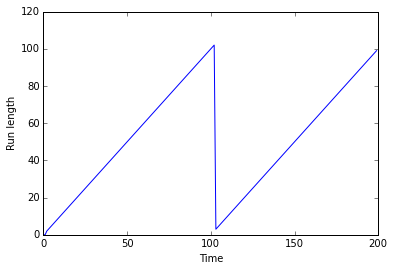

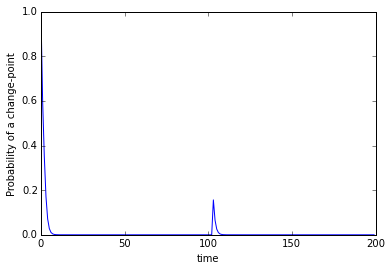

In [6]:
# Run Detection on Gaussian Distribution
data = [0] * 100 + [1] * 100


def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

Pr = changepoint_detection(data, hazard, Gaussian(0.1, 0.1, 0, 1))

plt.plot([Pr[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([Pr[0, t] for t in range(len(data))])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

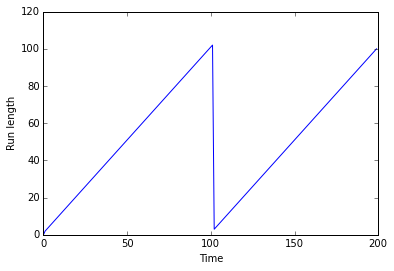

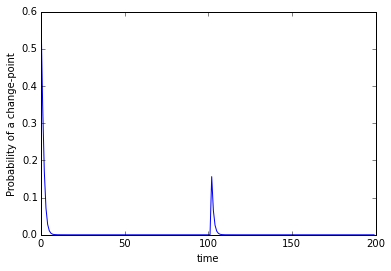

In [7]:
data = [0] * 100 + [1] * 100


def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

detector = BayesianChangepointDetection(hazard, Gaussian(0.1, 0.1, 0, 1))

Pr = [detector.step(x) for x in data]

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([pr[0] for pr in Pr])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

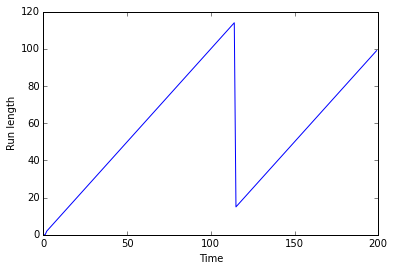

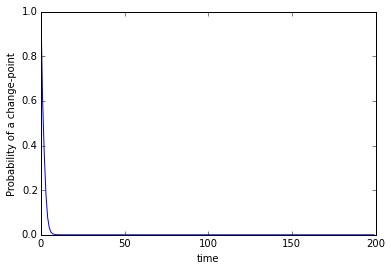

In [8]:
data = [0] * 100 + [1] * 100


def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

Pr = changepoint_detection(data, hazard, StudentT(0.1, 0.1, 1, 1))

plt.plot([Pr[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([Pr[0, t] for t in range(len(data))])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

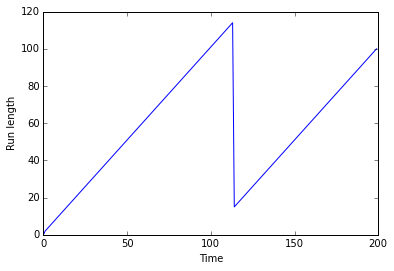

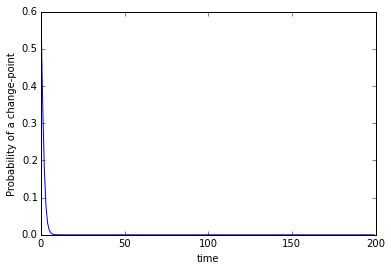

In [9]:
data = [0] * 100 + [1] * 100


def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

detector = BayesianChangepointDetection(hazard, StudentT(0.1, 0.1, 1, 1))

Pr = [detector.step(x) for x in data]

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([pr[0] for pr in Pr])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()